In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os, glob
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root_folder = "/content/drive/My Drive/Datathon/"
topics_path = os.path.join(root_folder,"interest_topics.csv")
train_path = os.path.join(root_folder,"training.csv")
test_path = os.path.join(root_folder,"validation.csv")

In [4]:
def load(file):
    import ast
    df = pd.read_csv(file)

    # convert the column values from literal string to dictionary
    df['ltiFeatures'] = df['ltiFeatures'].apply(ast.literal_eval)
    df['stiFeatures'] = df['stiFeatures'].apply(ast.literal_eval)
    return df

# load all data
training = load(train_path)
test = load(test_path)
interest_topics = pd.read_csv(topics_path)

# inspect data
interest_topics.head()
training.head()
test.head()

,userID,inAudience,ltiFeatures,stiFeatures
0,0,True,"{'89': 0.0027281240558934, '1264': 0.001862958...",{}
1,1,True,"{'47': 0.0019292939671486482, '1187': 0.012261...",{}
2,2,True,"{'45': 0.001961152113619305, '47': 0.001584126...",{}
3,3,True,"{'1253': 0.006566573072362829, '1164': 0.00327...",{}
4,4,True,"{'78': 0.013096540307802428, '1198': 0.0025546...",{}


In [0]:
def convert_data_to_im(data):
    r = int(np.shape(data)[0])  # No. of users
    max_c = []
    for i in range(r):
        user_lti = data.at[i, 'ltiFeatures']
        user_sti = data.at[i, 'stiFeatures']
        c_l = max([int(i) for i in user_lti.keys()])
        if user_sti != {}:
            c_s = max([int(i) for i in user_sti.keys()])
        else:
            c_s = 0
        max_c.append(max(c_l, c_s))
    c = max(max_c)
    print(c)
    im = np.zeros((r, 2, c))
    for i in range(r):  # iterate users
        user_lti = data.at[i, 'ltiFeatures']
        user_sti = data.at[i, 'stiFeatures']
        for k in user_lti.keys():
            im[i, 0, int(k)-1] = user_lti[k]
        for k in user_sti.keys():
            im[i, 1, int(k)-1] = user_sti[k]
    return im


def ground_truth(data):
    gt = data.to_numpy()[:, 1]
    for i in range(int(np.shape(data)[0])):
        if gt[i]:
            gt[i] = 1
        else:
            gt[i] = 0
    return gt

In [6]:
im = convert_data_to_im(training)
# (96406,2,1881)
label = ground_truth(training)
# (96406,)

1881


In [59]:
im_test = convert_data_to_im(test)
im_test_dim = np.expand_dims(im_test,axis=3)
print(np.shape(im_test_dim))
label_test = ground_truth(test)
print(np.shape(label_test))

1881
(80008, 2, 1881, 1)
(80008,)


In [7]:
np.shape(im)

(96406, 2, 1881)

In [8]:
im_dim = im.reshape(np.shape(im)[0],np.shape(im)[1],np.shape(im)[2],1)
print(np.shape(im_dim))

(96406, 2, 1881, 1)


In [9]:
assert np.shape(label)[0] == np.shape(im_dim)[0]
num_shopper = np.shape(label)[0]
im_dim.astype(np.float32)
label.astype(np.int32)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(im_dim, label, test_size=0.1, random_state=42)



In [90]:
np.shape(X_train)

(86765, 2, 1881, 1)

In [91]:
model = tf.keras.Sequential([])

model.add(tf.keras.layers.Conv2D(32, (2, 3), 1, padding='same', input_shape=(2,1881,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, (2, 3), 1, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 2)))

# model.add(tf.keras.layers.Conv2D(64, (2, 3), 1, padding='same', activation='relu'))
# model.add(tf.keras.layers.Conv2D(64, (2, 3), 1, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
            optimizer=tf.train.AdamOptimizer(0.01),
            metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 2, 1881, 32)       224       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 2, 1881, 32)       6176      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 2, 940, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 60160)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               15401216  
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)             

In [92]:
# kf = KFold(n_splits=10)
# kf.get_n_splits(im)
history = []
accs = []
evals = []

# for train_index, val_index in kf.split(im):
  #  X_train, X_val = im_dim[train_index], im_dim[val_index]
  #  y_train, y_val = label[train_index], label[val_index]
   # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)

   # checkpoint = ModelCheckpoint(filepath, monitor = 'acc', verbose = 1, save_best_only = True, mode = 'max')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(root_folder,'logs/{}').format('model_name'))
hist = model.fit(X_train, y_train,
      batch_size=64,
      epochs=5,
      verbose=1,
      validation_data=(X_val, y_val),
      callbacks=[tensorboard])
history.append(hist.history)
predictions = model.predict(im_test_dim)
a = 1*(predictions<0.5)
b = np.asarray([i-j for i,j in zip(a,label_test)])
acc = np.sum(b)/len(b)
print(acc)
accs.append(acc)
label_test_dim = np.expand_dims(label_test,axis=3).astype(np.int32)
metric = metrics.confusion_matrix(label_test_dim,a)
evals.append(metric)

Train on 86765 samples, validate on 9641 samples
Epoch 1/5
86765/86765 [==============================] - 108s 1ms/sample - loss: 0.1295 - acc: 0.9843 - val_loss: 0.0815 - val_acc: 0.9841
Epoch 2/5
86765/86765 [==============================] - 107s 1ms/sample - loss: 0.0816 - acc: 0.9848 - val_loss: 0.0816 - val_acc: 0.9841
Epoch 3/5
86765/86765 [==============================] - 118s 1ms/sample - loss: 0.0794 - acc: 0.9849 - val_loss: 0.0818 - val_acc: 0.9841
Epoch 4/5
86765/86765 [==============================] - 107s 1ms/sample - loss: 0.0790 - acc: 0.9849 - val_loss: 0.0834 - val_acc: 0.9841
Epoch 5/5
86765/86765 [==============================] - 107s 1ms/sample - loss: 0.0801 - acc: 0.9849 - val_loss: 0.0827 - val_acc: 0.9841
0.9922507749225078


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


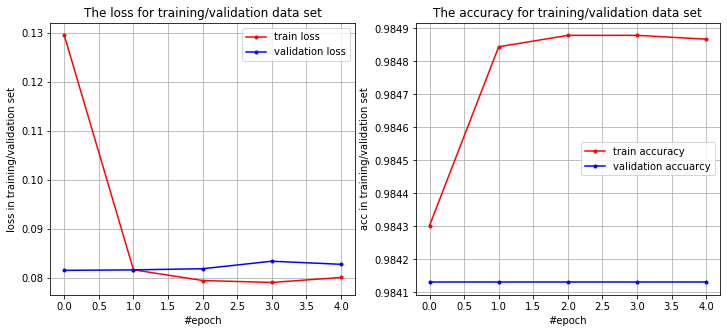

In [97]:
acc = history[0]['acc']
loss = history[0]['loss']
val_acc = history[0]['val_acc']
val_loss = history[0]['val_loss']
epoch = range(5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch,loss,'r.-',label = 'train loss')
plt.plot(epoch,val_loss,'b.-', label = 'validation loss')
plt.title('The loss for training/validation data set')
plt.xlabel('#epoch')
plt.ylabel('loss in training/validation set')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch,acc,'r.-',label = 'train accuracy')
plt.plot(epoch,val_acc,'b.-',label = 'validation accuarcy')
plt.title('The accuracy for training/validation data set')
plt.xlabel('#epoch')
plt.ylabel('acc in training/validation set')
plt.grid()
plt.legend()

plt.show()

No handles with labels found to put in legend.


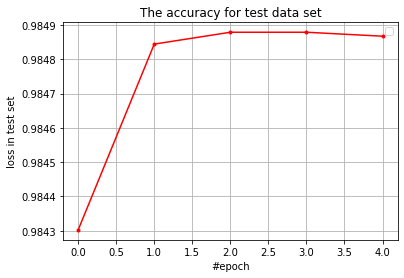

In [100]:

plt.plot(epoch,acc,'r.-')
plt.title('The accuracy for test data set')
plt.xlabel('#epoch')
plt.ylabel('loss in test set')
plt.grid()
plt.legend()